<a href="https://colab.research.google.com/github/Voidspaceinuniverse/Project/blob/main/Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fake_useragent

In [2]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек
import time          # Библиотека для времени
import os
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm import tqdm_notebook
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
def get_one_page(page) -> int:

    """Функция извлекает данные с одной страницы сайта Metacritic, переданной номером в параметры функции и возвращает словарь"""

    url = f"https://www.metacritic.com/browse/movie/?releaseYearMin=1910&releaseYearMax=2023&page={page}"
    html = requests.get(url, headers={'User-Agent': UserAgent().firefox})
    if not html.ok:
        # если сервер отказал, вернем статус ошибки
        print(html)
    soup = BeautifulSoup(html.text, 'html.parser')
    massive = soup.findAll(attrs = {'class':'c-finderProductCard_container g-color-gray80 u-grid'})

    dict = {'title': [], 'movie_page': [], 'metascore': [], 'number_of_critical_reviews': [], 'user_score':[], 'number_of_user_reviews': [], 'genre': [], 'director': [], 'year':[], 'duration':[], 'attribute':[], 'summary':[]}

    for element in tqdm_notebook(massive):
        try:
            movie_page = 'https://metacritic.com' + element.get('href')
            dict['movie_page'] += [movie_page]


            response = requests.get(movie_page, headers={'User-Agent': UserAgent().chrome})
            if not response.ok:
              # если сервер отказал, вернем статус ошибки
              print(response)
              continue
            html = response.content
            soup = BeautifulSoup(html,'html.parser')

            try:
              obj = soup.find(attrs = {'class':'c-productHero_title g-inner-spacing-bottom-medium g-outer-spacing-top-medium'})
              title = obj.text.strip()
              dict['title'] += [title]
            except:
              dict['title'] += ['-']

            try:
              obj = soup.find(attrs = {'class':'c-productScoreInfo_scoreNumber u-float-right'})
              metascore = int(obj.text)
              dict['metascore'] += [metascore]
            except:
              dict['metascore'] += ['-']

            try:
              obj = soup.find(attrs = {'class':'g-color-gray80 u-text-underline'})
              number_of_critical_reviews = int(obj.text.split()[2])
              dict['number_of_critical_reviews'] += [number_of_critical_reviews]
            except:
              dict['number_of_critical_reviews'] += ['-']

            try:
              obj = soup.find(attrs = {'title': re.compile("User score")})
              user_score = float(obj.text)
              dict['user_score'] += [user_score]
            except:
              dict['user_score'] += ['-']

            try:
              obj = soup.findAll(attrs = {'class':'g-color-gray80 u-text-underline'})
              number_of_user_reviews = int(obj[1].text.split()[2])
              dict['number_of_user_reviews'] += [number_of_user_reviews]
            except:
              dict['number_of_user_reviews'] += ['-']

            try:
              obj = soup.findAll(attrs = {'class':'c-genreList_item'})
              genre = []
              for item in obj:
                genre.append(item.text.strip())
              dict['genre'] += [set(genre)]
            except:
              dict['number_of_user_reviews'] += ['-']

            try:
              obj = soup.find(attrs = {'class':'c-crewList_link u-text-underline'})
              director = obj.text.strip()
              dict['director'] += [director]
            except:
              dict['director'] += ['-']

            try:
              obj = soup.find(attrs = {'class':'u-inline'})
              att = [elem for elem in (list(map(str.strip, obj.text.split("\n")))) if elem]
            except:
              continue

            try:
              year = int(att[0])
              dict['year'] += [year]
            except:
              dict['year'] += ['-']

            try:
              duration = int(att[-1][0]) * 60 + int(att[-1][4:6])
              dict['duration'] += [duration]
            except:
              dict['duration'] += ['-']

            try:
              obj = soup.find(attrs = {'class':'u-inline'})
              att = [elem for elem in (list(map(str.strip, obj.text.split("\n")))) if elem]
              dict['attribute'] += [att]
            except:
              dict['attribute'] += ['-']

            try:
              obj = soup.find(attrs = {'class':'c-productDetails_summary g-text-xsmall'})
              summary = obj.text.strip()[8:]
              dict['summary'] += [summary]
            except:
              dict['summary'] += ['-']

            time.sleep(random.randrange(1,2))

        except:
            continue

    return dict

In [4]:
def get_all_page(a = 1, b = 1086) -> int:

    """Функция извлекает данные сайта Metacritic, в диапозоне переданном в параметры функции, либо все страницы, и возвращает датафрэйм с данными"""

    final_df = pd.DataFrame()
    for page in tqdm_notebook(range(a, b+1)):
        try:
            data = get_one_page(page)
            final_df = pd.concat([final_df, pd.DataFrame(data)])
            time.sleep(0.3)
        except:
            continue
    return final_df

In [ ]:
# Извдекаем данные и схраняем в формате CSV
data = get_all_page()
data.to_csv(r"/content/drive/MyDrive/Colab Notebooks/NLP Course/Metacritic_parce_data_complited_new.csv", index=False, sep=";")

In [5]:
# Открываем датафрэйм считывая сохраненый файл
os.chdir('/content/drive/MyDrive/Colab Notebooks/NLP Course/')
pd.set_option('display.max_columns', None)
df = pd.read_csv('Metacritic_parce_data_complited_new.csv', sep=';')
df = df.drop(['index'], axis=1)

In [18]:
df

,title,movie_page,metascore,number_of_critical_reviews,user_score,number_of_user_reviews,genre,director,year,duration,attribute,summary
0,Dekalog (1988),https://metacritic.com/movie/dekalog-1988/,100,13,7.6,50,{'Drama'},Krzysztof Kieslowski,1996,572,"['1996', 'TV-MA', 'Facets Multimedia Distribut...",This masterwork by Krzysztof Kieślowski is one...
1,Tokyo Story,https://metacritic.com/movie/tokyo-story/,100,18,8.1,110,{'Drama'},Yasujirô Ozu,1972,136,"['1972', 'Not Rated', 'New Yorker Films', '2 h...",Yasujiro Ozu’s Tokyo Story follows an aging co...
2,Celine and Julie Go Boating (1974),https://metacritic.com/movie/celine-and-julie-...,100,7,6.7,0,"{'Mystery', 'Drama', 'Fantasy', 'Comedy'}",Jacques Rivette,2012,193,"['2012', 'Unrated', 'New Yorker Films', '3 h 1...",This magical tale recounts the adventures of J...
3,Lawrence of Arabia (re-release),https://metacritic.com/movie/lawrence-of-arabi...,100,8,8.6,395,"{'Biography', 'Adventure', 'War', 'Drama'}",David Lean,2002,218,"['2002', 'PG', 'Columbia Pictures', '3 h 38 m']",The 40th anniversary re-release of David Lean'...
4,Best Kept Secret,https://metacritic.com/movie/best-kept-secret/,100,40,6.6,0,"{'Drama', 'Documentary'}",Samantha Buck,2013,85,"['2013', 'Not Rated', 'Argot Pictures', '1 h 2...","JFK High School, located in the midst of a run..."
...,...,...,...,...,...,...,...,...,...,...,...,...
15569,Boogie Woogie,https://metacritic.com/movie/boogie-woogie/,0,11,5.9,7,"{'Drama', 'Comedy'}",Duncan Ward,2010,94,"['2010', 'R', 'IFC Films', '1 h 34 m']",A comedy of manners set against the backdrop o...
15570,The Box Head Revolution,https://metacritic.com/movie/the-box-head-revo...,0,9,0.0,0,set(),Mark Christensen,2002,76,"['2002', '1 h 16 m']",NaN
15571,The Bridge,https://metacritic.com/movie/the-bridge-2000/,0,12,0.0,0,"{'Romance', 'Drama'}","Frédéric Auburtin,",2000,95,"['2000', 'Phaedra Cinema', '1 h 35 m']",The world of a young housewife is turned upsid...
15572,7th Street,https://metacritic.com/movie/7th-street/,0,7,0.0,0,{'Documentary'},Josh Pais,2003,72,"['2003', 'IndieFlix', '1 h 12 m']",This documentary explores change in one of the...


In [6]:
df.shape

(15574, 12)

In [7]:
df = df.drop_duplicates()
df = df.replace(['-'],'0')
df = df.replace(['---'],'0')
df['year'] = df['year'].fillna(0).astype(int)
df['duration'] = df['duration'].fillna(0).astype(int)
df['metascore'] = df['metascore'].fillna(0).astype(float).astype(int)
df['number_of_critical_reviews'] = df['number_of_critical_reviews'].fillna(0).astype(float).astype(int)
df['user_score'] = df['user_score'].fillna(0).astype(float)
df['number_of_user_reviews'] = df['number_of_user_reviews'].fillna(0).astype(int)

In [8]:
df.shape

(12073, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12073 entries, 0 to 15573
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       12073 non-null  object 
 1   movie_page                  12072 non-null  object 
 2   metascore                   12073 non-null  int64  
 3   number_of_critical_reviews  12073 non-null  int64  
 4   user_score                  12073 non-null  float64
 5   number_of_user_reviews      12073 non-null  int64  
 6   genre                       12072 non-null  object 
 7   director                    12072 non-null  object 
 8   year                        12073 non-null  int64  
 9   duration                    12073 non-null  int64  
 10  attribute                   12072 non-null  object 
 11  summary                     12070 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ MB


In [10]:
df.describe()

,metascore,number_of_critical_reviews,user_score,number_of_user_reviews,year,duration
count,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000,12073.000000
mean,59.948811,18.679036,4.727417,62.429802,1981.360225,102.199785
std,18.235605,11.802225,3.154256,132.728454,222.017748,25.230945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,9.000000,0.000000,0.000000,2001.000000,91.000000
50%,61.000000,16.000000,6.000000,11.000000,2010.000000,100.000000
75%,74.000000,26.000000,7.300000,53.000000,2017.000000,112.000000
max,100.000000,202.000000,9.700000,997.000000,2024.000000,572.000000


<ipython-input-17-2b6e2b15dca9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='spearman')


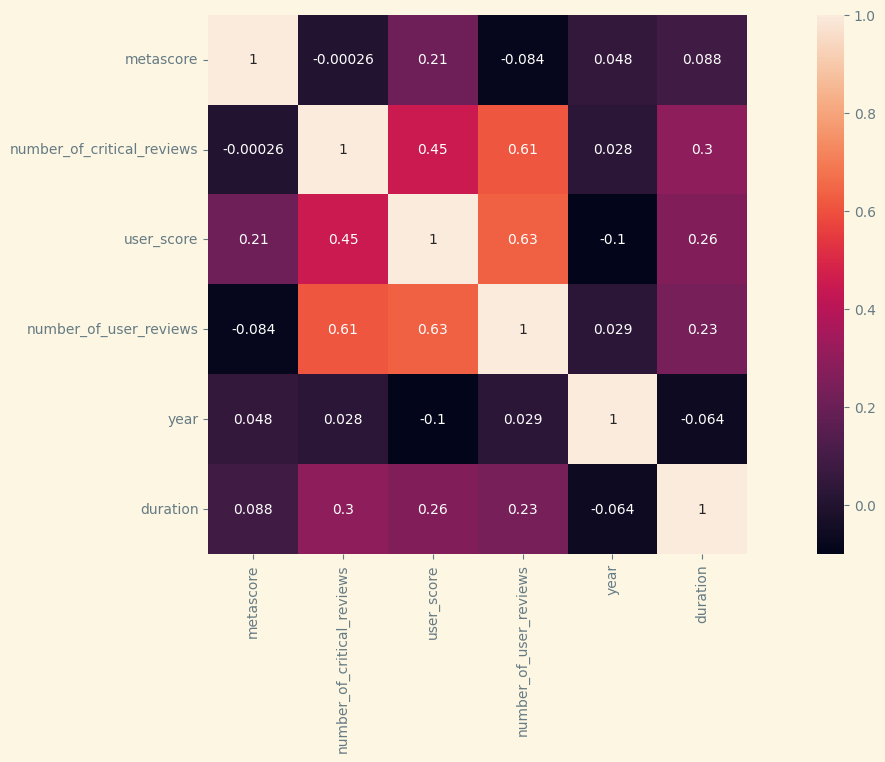

In [17]:
corr = df.corr(method='spearman')
plt.figure(figsize=(18,7))
sns.heatmap(corr,vmax=1,square=True,annot=True)
plt.show()

<ipython-input-19-fd6a6eba0688>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method='pearson')


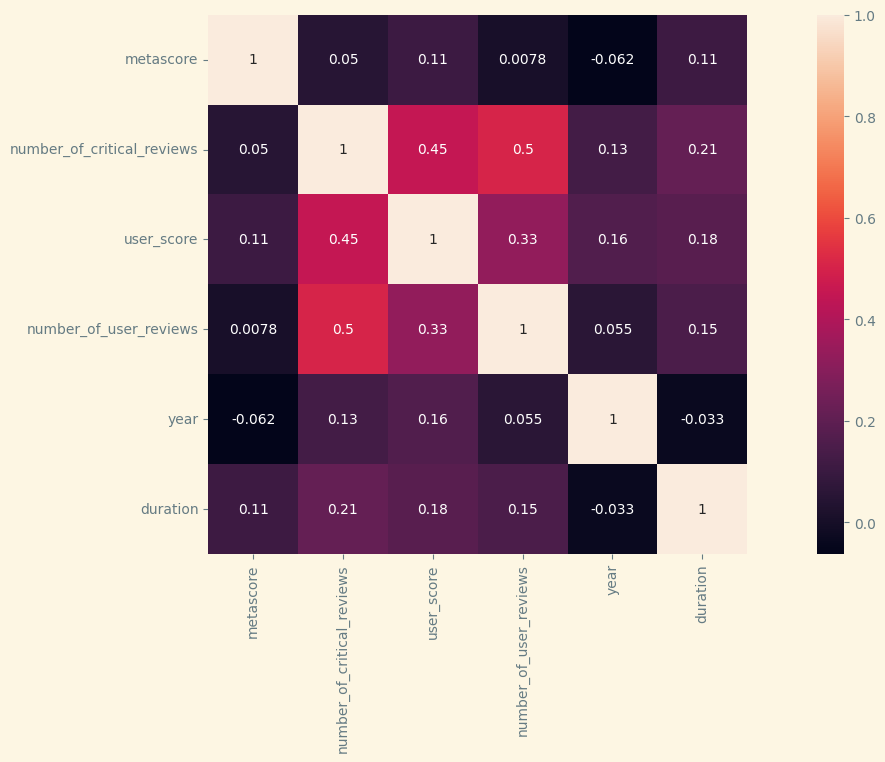

In [19]:
corr = df.corr(method='pearson')
plt.figure(figsize=(18,7))
sns.heatmap(corr,vmax=1,square=True,annot=True)
plt.show()

In [12]:
plt.style.use('Solarize_Light2')

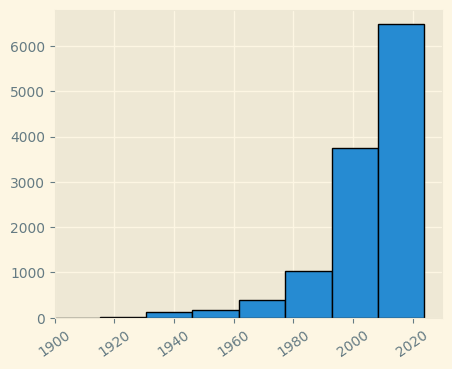

In [13]:
df['year'].hist(figsize=(5,4), histtype='bar', bins = 130, edgecolor='black')
plt.xticks(rotation=35)
plt.xlim(1900, 2030)
plt.show()

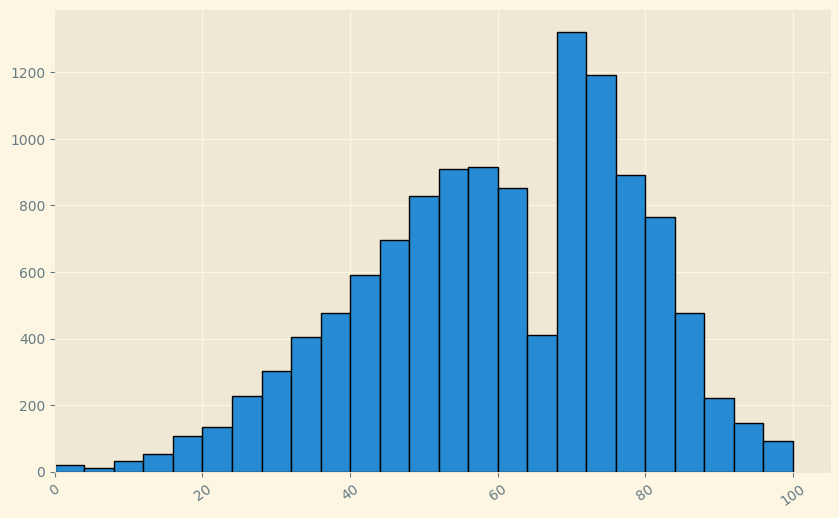

In [14]:
df['metascore'].hist(figsize=(10,6), histtype='bar', bins= 25, edgecolor='black')
plt.xticks(rotation=35)
plt.xlim(0)
plt.show()

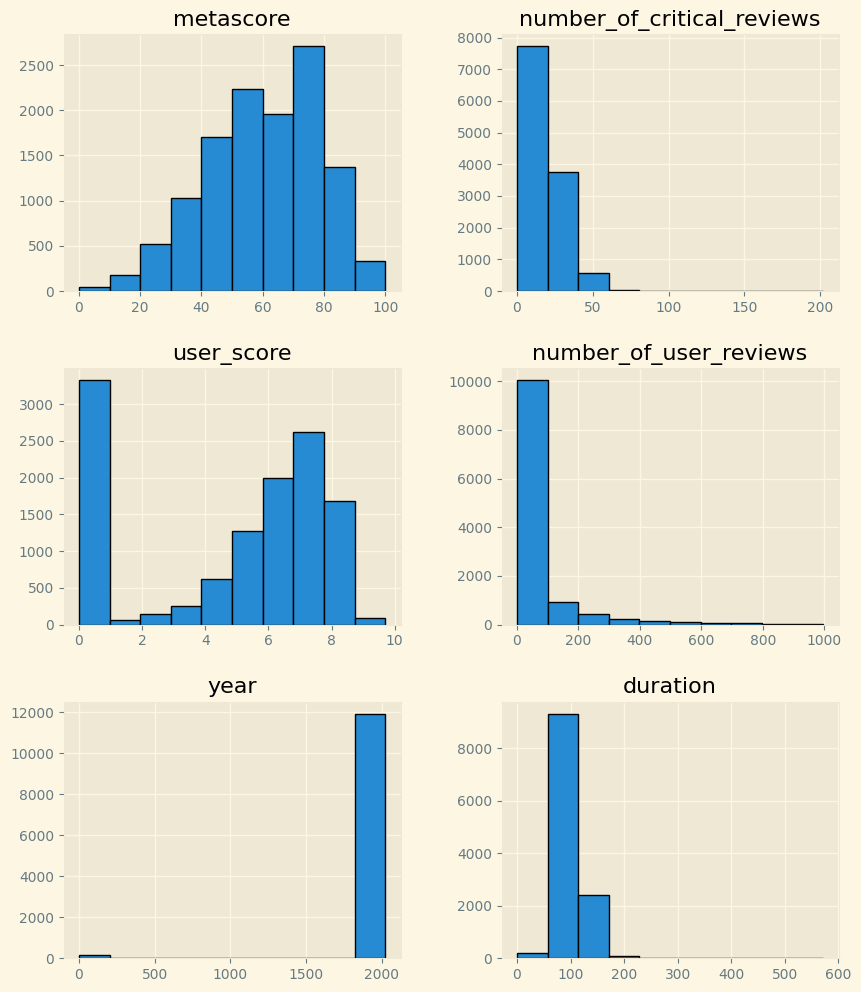

In [15]:
df.hist(figsize=(10,12), edgecolor='black')
plt.show()